In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import os
import sys

os.chdir("C:/Users/user/Victor/Trabajo/ExtremeCorrection/")
sys.path.append(os.path.abspath('C:/Users/user/Victor/Trabajo/ExtremeCorrection/src'))

# Illustrative example

In this notebook the Illustrative example of paper "Point-in-time and extreme-value probability simulation technique for engineering design" R. Mínguez et al. (2012) is used to check the new Extreme Correction technique.

The example generates an ARMA process to generate the historical data and then correct a new simulated data.

## Generate Historical data with ARMA 

The ARMA(1,1) is generated with parameters $\phi_1 = -0.8$, $\theta_1 = 0.3$ and variance $\sigma_{\epsilon}^2 = 1$.

In [2]:
# Define ARMA parameters
phi_1 = -0.8
theta_1 = 0.3
sigma_eps = 1.0

In [3]:
sigma_z = np.sqrt((1+theta_1**2-2*phi_1*theta_1)/(1-phi_1**2)*sigma_eps**2)
sigma_z

2.0883273476902784

In [4]:
np.random.seed(42)  # For reproducibility

ar = np.array([1, phi_1])      
ma = np.array([1, theta_1])

n_hist = int(100*24*365.25)
# Define the ARMA process
arma_process = ArmaProcess(ar, ma)

hist_sample = arma_process.generate_sample(nsample=n_hist, scale=sigma_eps)

In [5]:
hist_sample

array([ 0.49671415,  0.40812127,  0.93270626, ..., -1.07623159,
       -0.69985485, -0.48101119])

In [6]:
# Starting date within the safe pandas timestamp range
start_date = '2000-01-01 00:00:00'

# Generate date range in 100 years chunks
date_range = pd.date_range(start=start_date, periods=n_hist, freq=f'h')  

In [7]:
date_range.year

Index([2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
       ...
       2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099],
      dtype='int32', length=876600)

In [8]:
df_hs = pd.DataFrame({
    'time': date_range,
    'Hs': hist_sample,
    'yyyy': date_range.year,
    'mm': date_range.month,
    'dd': date_range.day,
    'hh': date_range.hour
})

df_hs.head()

,time,Hs,yyyy,mm,dd,hh
0,2000-01-01 00:00:00,0.496714,2000,1,1,0
1,2000-01-01 01:00:00,0.408121,2000,1,1,1
2,2000-01-01 02:00:00,0.932706,2000,1,1,2
3,2000-01-01 03:00:00,2.463501,2000,1,1,3
4,2000-01-01 04:00:00,2.193557,2000,1,1,4


## Generate Simulated Data

If data was previously simulated, load the data and do not run the following code

In [9]:
df_sim = pd.read_csv("Data/IllExample/df_sim_gaussmix.csv")

In [17]:
from src.arma_sim import ArmaSimulation

arma = ArmaSimulation(df_hs, var='Hs', freq=24*365.25, arma_order=(1,0,1), distribution="gaussmix", n_components=4)
ny_sim = 100
hs_sim = arma.generate_sim(ny_sim = ny_sim)   # We select the number of years of simulations

100%|██████████| 876600/876600 [23:35<00:00, 619.20it/s]


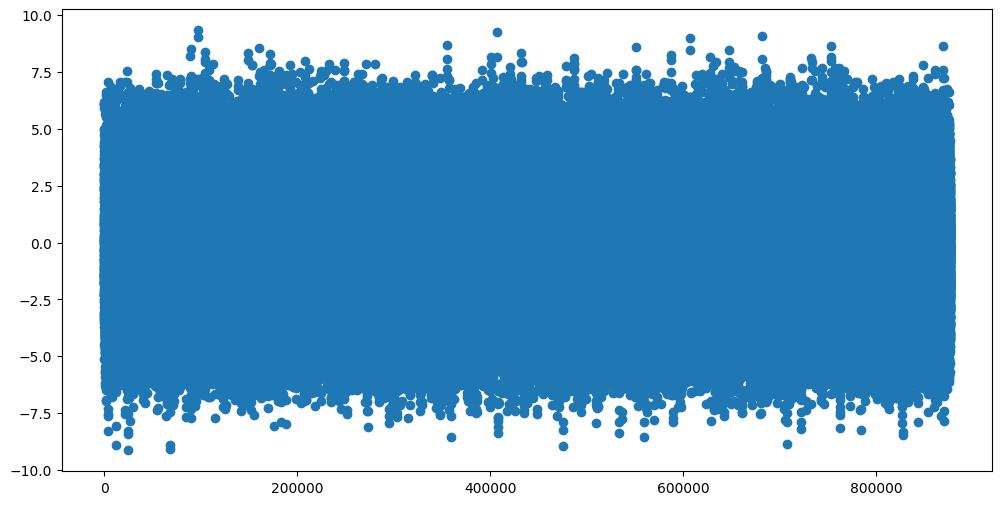

In [19]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(0,int(ny_sim*24*365.25)), hs_sim)
plt.show()

In [20]:
# Starting date within the safe pandas timestamp range
start_date = '2000-01-01 00:00:00'

# Generate date range in 100 years chunks
date_range = pd.date_range(start=start_date, periods=int(ny_sim*365.25*24), freq=f'h')  

In [21]:
year_simulated = np.array([], dtype=np.int32)
month_simulated = np.array([], dtype=np.int32)
day_simulated = np.array([], dtype=np.int32)
hour_simulated = np.array([], dtype=np.int32)
for i in range(len(hs_sim)//len(date_range)):
    year_simulated = np.concatenate([year_simulated, date_range.year + 100*i])
    month_simulated = np.concatenate([month_simulated, date_range.month])
    day_simulated = np.concatenate([day_simulated, date_range.day])
    hour_simulated = np.concatenate([hour_simulated, date_range.hour])

df_sim = pd.DataFrame({
    'yyyy': year_simulated,
    'mm':  month_simulated,
    'dd': day_simulated,
    'hh': hour_simulated,
    'Hs': hs_sim
})

In [22]:
df_sim.head()

,yyyy,mm,dd,hh,Hs
0,2000,1,1,0,-1.215183
1,2000,1,1,1,0.225532
2,2000,1,1,2,0.095420
3,2000,1,1,3,-0.555696
4,2000,1,1,4,-0.253077


In [23]:
df_sim.to_csv("Data/IllExample/df_sim_gaussmix.csv")

## Correction using Annual Maxima

In [10]:
from src.extremecorrection import Gev_ExtremeCorrection

config = {
    'var': 'Hs',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.25*24,
    'folder': 'Figures/IllExample'
}

Initialize the correction

In [11]:
extr_corr = Gev_ExtremeCorrection(
    data = df_hs,
    config = config,
    conf = 0.95
)

### Apply historical correction

In [12]:
extr_corr.apply_correction(fit_diag=True)   # fit_diag = True, to plot the diagnostics plots (QQ-Plot and PP-plot)
extr_corr.return_period_plot()              # Default to plot only the no corrected data 

In [13]:
extr_corr.gev_parameters    # shape parameter has changed the sign

[7.368531944937001, 0.5218719697052451, 0.17291867943854888]

### Apply simulated correction

In [14]:
extr_corr.apply_correction_sim(simulated_data = df_sim)   # Apply the correction in the simulated data
extr_corr.sim_return_period_plot()                        # Default to plot the corrected and no corrected data
extr_corr.interval_sim_return_period_plot()               # Comparative of no corrected vs corrected simulated data in the historical range
extr_corr.time_series_plot(sim=False)                     # Time series of both corrected and no-corrected data

Dataframe with the corrected simulation

In [15]:
new_sim_data = extr_corr.sim_pit_data_corrected
new_df_sim = df_sim.copy()
new_df_sim['Hs'] = new_sim_data

In [16]:
new_df_sim.to_csv("Data/IllExample/df_sim_gaussmix_corr_GEV.csv")

### Obtener POTs de la serie tanto corregida con GEV como sin corregir

In [17]:
from src.optimal_threshold_studentized import OptimalThreshold

In [18]:
opt_thres = OptimalThreshold(df_hs['Hs'].values)
opt_thres.threshold_peak_extraction(
    threshold=0.1,
    n0=10,
    min_peak_distance=2*24
)

optimal_threshold = opt_thres.threshold_studentized_residuals(
                siglevel=0.01,
                plot_flag=True,
                filename=f"{extr_corr.folder}/OptimalThreshold/OptimalThreshold",
                display_flag=False
                )

opt_thres.threshold_peak_extraction(
    threshold=optimal_threshold,
    n0=10,
    min_peak_distance=2*24
)

In [19]:
optimal_threshold

array([4.4695481])

In [20]:
hist_poiss_param = len(opt_thres.pks) / 100

Simulación sin corregir

In [21]:
opt_thres_sim = OptimalThreshold(df_sim['Hs'].values)
opt_thres_sim.threshold_peak_extraction(
    threshold=optimal_threshold,
    n0=10,
    min_peak_distance=2*24
)
sim_poiss_param = len(opt_thres_sim.pks) / 100

Simulación corregida

In [22]:
opt_thres_sim_corrected = OptimalThreshold(new_df_sim['Hs'].values)
opt_thres_sim_corrected.threshold_peak_extraction(
    threshold=optimal_threshold,
    n0=10,
    min_peak_distance=2*24
)
sim_poiss_param_corrected = len(opt_thres_sim_corrected.pks) / 100

In [23]:
print("Historical Poisson parameter:", hist_poiss_param)
print("Simulation Poisson parameter:", sim_poiss_param)
print("Corrected Simulation Poisson parameter:", sim_poiss_param_corrected)

Historical Poisson parameter: 45.07
Simulation Poisson parameter: 45.4
Corrected Simulation Poisson parameter: 45.4


Gráfico

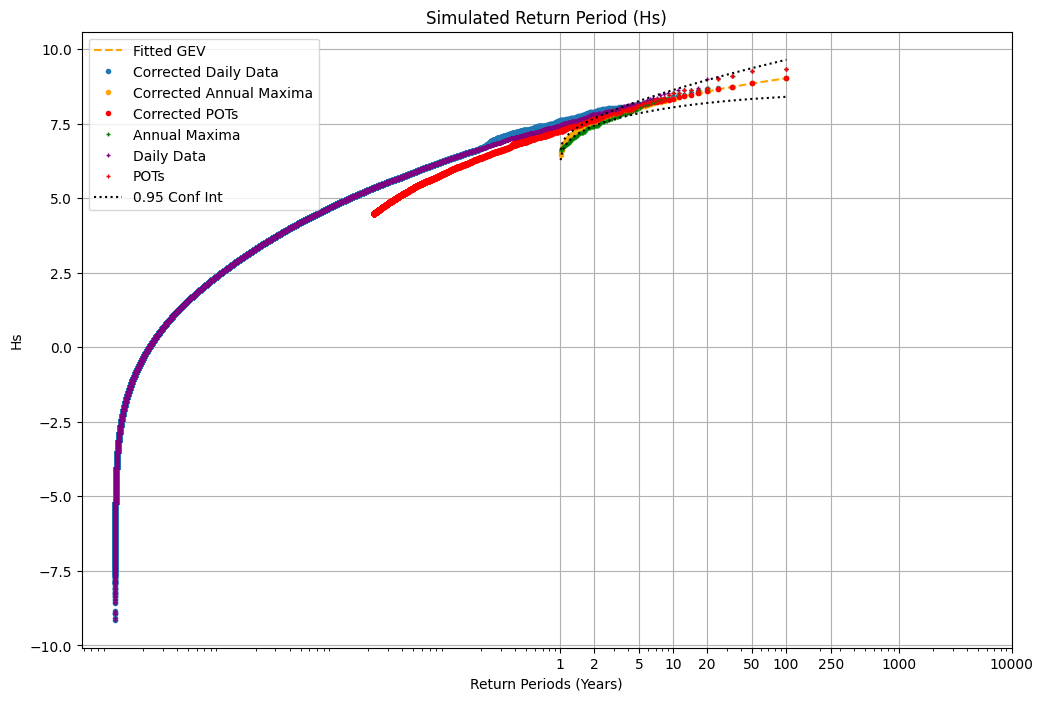

In [24]:
from scipy import stats
from src.gev_utils import dq_gev, nll_gev
import numdifftools as ndt

x_vals_gev_sim = np.linspace(extr_corr.sim_max_data_corrected[0], extr_corr.sim_max_data_corrected[-1], 1000)
# Return period from GEV fitted
gev_probs_fitted = stats.genextreme.cdf(x_vals_gev_sim, extr_corr.gev_parameters[2], loc=extr_corr.gev_parameters[0], scale=extr_corr.gev_parameters[1])
T_gev_fitted = 1.0 / (1.0 - gev_probs_fitted) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# Corrected peaks: re-check CDF and return periods
ecdf_annmax_probs_corrected_sim = stats.genextreme.cdf(
    stats.genextreme.ppf(extr_corr.ecdf_annmax_probs_sim, extr_corr.gev_parameters[2], loc=extr_corr.gev_parameters[0], scale=extr_corr.gev_parameters[1]),
    extr_corr.gev_parameters[2], loc=extr_corr.gev_parameters[0], scale=extr_corr.gev_parameters[1]
)
T_ev_corrected_sim = 1.0 / (1.0 - ecdf_annmax_probs_corrected_sim) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# Daily corrected data
ecdf_pt_probs_corrected_sim = np.arange(1, extr_corr.n_sim_pit + 1) / (extr_corr.n_sim_pit + 1)
T_pt_corrected_sim = 1.0 / (1.0 - ecdf_pt_probs_corrected_sim) / extr_corr.freq #/ n_return_period[wt] 

# POT (uncorrected)
T_pot_sim = 1.0 / (1.0 - extr_corr.ecdf_annmax_probs_sim) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# Confidence intervals
dqgev_sim = dq_gev(extr_corr.ecdf_annmax_probs_sim, p=[extr_corr.gev_parameters[0], extr_corr.gev_parameters[1], extr_corr.gev_parameters[2]])
aux_fun = lambda x: nll_gev(extr_corr.max_data, x)
hess = ndt.Hessian(aux_fun, step=1e-4)  # Añado el step para que no de problemas de inestabilidad
hessians_gev_sim = hess([extr_corr.gev_parameters[0], extr_corr.gev_parameters[1], extr_corr.gev_parameters[2]])
invI0_gev_sim = np.linalg.inv(hessians_gev_sim)

stdDq_gev_sim = np.sqrt(np.sum((dqgev_sim.T@invI0_gev_sim) * dqgev_sim.T, axis=1)) # Es lo mismo 
stdup_gev_sim = extr_corr.sim_max_data_corrected + stdDq_gev_sim*stats.norm.ppf(1-(1-extr_corr.conf)/2,0,1)
stdlo_gev_sim = extr_corr.sim_max_data_corrected - stdDq_gev_sim*stats.norm.ppf(1-(1-extr_corr.conf)/2,0,1)


# Plot
# Gráfico
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()
ax.semilogx(T_gev_fitted, np.sort(x_vals_gev_sim), color = 'orange',linestyle='dashed', label='Fitted GEV')

# Corrected data 
# if show_corrected:
ax.semilogx(T_pt_corrected_sim, np.sort(extr_corr.sim_pit_data_corrected), linewidth=0, marker='o',markersize=3, label=f'Corrected Daily Data')
ax.semilogx(T_ev_corrected_sim, stats.genextreme.ppf(extr_corr.ecdf_annmax_probs_sim, extr_corr.gev_parameters[2], loc=extr_corr.gev_parameters[0], scale=extr_corr.gev_parameters[1]), color = 'orange',linewidth=0, marker='o',markersize=3, label=f'Corrected Annual Maxima')

pots_corrected = new_df_sim['Hs'].values[opt_thres_sim_corrected.locs]
ecdf_pot_probs_corrected_sim = np.arange(1,len(pots_corrected)+1)/(len(pots_corrected)+1)
T_pot_corrected_sim = 1/(1-ecdf_pot_probs_corrected_sim)/hist_poiss_param
ax.semilogx(T_pot_corrected_sim, np.sort(pots_corrected), color = 'red',linewidth=0, marker='o',markersize=3, label=f'Corrected POTs')



# No corrected data
# if show_uncorrected:
ax.semilogx(T_pot_sim, extr_corr.sim_max_data_sorted, color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')
ax.semilogx(T_pt_corrected_sim, extr_corr.sim_pit_data_sorted, color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

pots_sim = df_sim['Hs'].values[opt_thres_sim.locs]
ecdf_pot_probs_sim = np.arange(1,len(pots_sim)+1)/(len(pots_sim)+1)
T_pot_sim = 1/(1-ecdf_pot_probs_sim)/hist_poiss_param
ax.semilogx(T_pot_sim, np.sort(pots_sim), color = 'red',linewidth=0, marker='+',markersize=3, label=f'POTs')

# Confidence interval for fitted GEV
ax.semilogx(T_ev_corrected_sim, stdup_gev_sim, color = "black",linestyle='dotted', label=f'{extr_corr.conf} Conf Int')
ax.semilogx(T_ev_corrected_sim, stdlo_gev_sim, color = "black",linestyle='dotted')

ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel(f"{extr_corr.var}")
ax.set_title(f"Simulated Return Period ({extr_corr.var})")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(right=10000)
ax.legend(loc='upper left')
ax.grid()
# if extr_corr.folder is not None:
    # plt.savefig(f"{extr_corr.folder}/Simulation_ReturnPeriod_con_POTs_1.png", dpi=300)
plt.show()
# plt.close(fig)

## Correction using POTs

In [25]:
from src.gpd_extremecorrection import GPD_ExtremeCorrection

config = {
    'var': 'Hs',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 24*365.25,
    'folder': 'Figures/IllExample_POT'
}

pot_config = {
    'n0': 10,
    'min_peak_distance': 2*24,
    'init_threshold': 0.1,
    'siglevel': 0.01,
    'plot_flag': True
}

Initialize the correction

In [26]:
extr_corr = GPD_ExtremeCorrection(
    data = df_hs,
    config = config,
    pot_config= pot_config,
    conf = 0.95
)

### Apply historical correction

In [27]:
extr_corr.apply_correction(fit_diag=True)   # fit_diag = True, to plot the diagnostics plots (QQ-Plot and PP-plot)
extr_corr.return_period_plot()              # Default to plot only the no corrected data 

C:\Users\user\Victor\Trabajo\ExtremeCorrection\src\gpd_extremecorrection.py:266: RuntimeWarning: invalid value encountered in sqrt
  stdDq_gpd = np.sqrt(np.sum((dqgpd.T@invI0_gpd) * dqgpd.T, axis=1))


In [28]:
extr_corr.opt_threshold, extr_corr.gpd_parameters    # shape parameter is positive, and the location parameter has to be considered 0 since the threshold is applied manually

(4.46954809534815, [0, 1.1397251987542814, -0.21762305459532888])

### Apply simulated correction

In [29]:
extr_corr.apply_correction_sim(simulated_data = df_sim)   # Apply the correction in the simulated data

In [30]:
print("Historical Poisson Parameter: ", extr_corr.poiss_parameter)
print("Simulated Poisson Parameter: ", extr_corr.sim_poiss_parameter)

Historical Poisson Parameter:  45.07
Simulated Poisson Parameter:  45.4


In [31]:
extr_corr.sim_return_period_plot()                        # Default to plot the corrected and no corrected data
extr_corr.interval_sim_return_period_plot()               # Comparative of no corrected vs corrected simulated data in the historical range
extr_corr.time_series_plot(sim=False)                     # Time series of both corrected and no-corrected data

C:\Users\user\Victor\Trabajo\ExtremeCorrection\src\gpd_extremecorrection.py:523: RuntimeWarning: invalid value encountered in sqrt
  stdDq_gpd_sim = np.sqrt(np.sum((dqgpd_sim.T@invI0_gpd_sim) * dqgpd_sim.T, axis=1)) # Es lo mismo


Dataframe with the corrected simulation

In [32]:
new_sim_data = extr_corr.sim_pit_data_corrected
new_df_sim = df_sim.copy()
new_df_sim['Hs'] = new_sim_data

In [33]:
new_df_sim.to_csv("Data/IllExample/df_sim_gaussmix_corr_POT.csv")